In [1]:
import os
import pandas as pd
import numpy as np

import socket, datetime, time

from _tclab import _tclabutils

print(f"author  {socket.gethostname():>28}")
print(f"version {str(datetime.datetime.now()):>28}")

author                           NOB
version   2023-06-16 04:33:09.809140


### data loading

data  model.4.6
size       4320


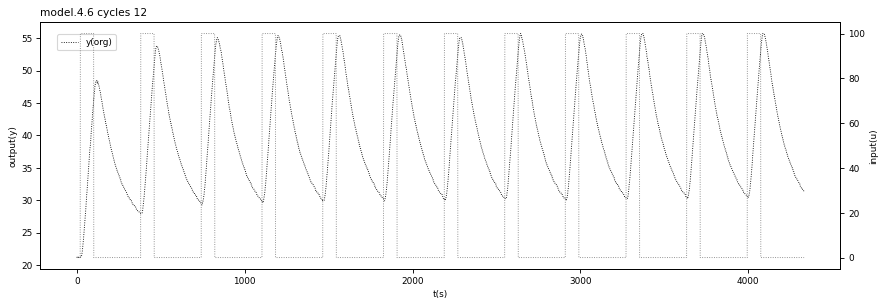

In [3]:

name = "model.4.6"
fname = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name))

from _helpers import Helpers_

t,u,y,data_size = Helpers_.tfload_(fname)

print(f"data {name:>10}")
print(f"size {data_size:>10}")

data = pd.read_csv(fname)

# cycle 
c = data["Cycle"].to_numpy().astype(np.int64)
cycles = np.unique(c)

# time
t = data["Time(ns)"].to_numpy().astype(np.int64)
t = ((t-t[0])/1e9).astype(np.int64)
# input
u = data["Q1"].to_numpy()
# output
y = data["T1"].to_numpy()

# plot 
#  input of u (switch)
#  output of y (temperature)

_tclabutils.plot(t,u,y,title="%s cycles %d"%(name,len(cycles)))

### fodpt estimation (first-order-plus-dead-time)

$\tau\frac{dy(t)}{dt}=-y(t)+Ku(t-\theta)$

parameters to estimate

$\tau$: time constant   
$\theta$: dead time  
$K$: gain  

In [6]:
%%time

# retrieve coefficients of fopdt K,tau,theta

from gekko import GEKKO

def estimate_coefficients_(t,u,y):

  m = GEKKO(remote=False)
  m.time = t
  time = m.Var(0)
  m.Equation(time.dt()==1)

  # gain
  K = m.FV(lb=0,ub=10);      K.STATUS=1

  # time constant
  tau = m.FV(lb=1,ub=200);   tau.STATUS=1

  # dead time
  theta = m.FV(lb=1,ub=20);  theta.STATUS=1

  # input: cubic spline
  tc = m.Var(t)
  uc = m.Var(u)
  m.Equation(tc==time-theta)
  m.cspline(tc,uc,t,u,bound_x=False)

  ym = m.Param(y)
  yp = m.Var(y)
  m.Equation(tau*yp.dt()+(yp-y[0])==K*(uc-uc[0]))

  m.Minimize((yp-ym)**2)

  m.options.IMODE = 5
  m.solve(disp=False)
  
  up,yp = np.array(uc),np.array(yp)
  ep = np.abs(y-yp)

  return K.value[0],tau.value[0],np.round(theta.value[0],0).astype(np.int64),up,yp,ep

K,tau,theta,up,yp,ep = estimate_coefficients_(t,u,y)

print("K=%f tau=%f theta=%d"%(K,tau,theta))

K=0.861933 tau=186.772334 theta=14
CPU times: total: 31.2 ms
Wall time: 3min 23s


### predicted estimation

cummulative error included

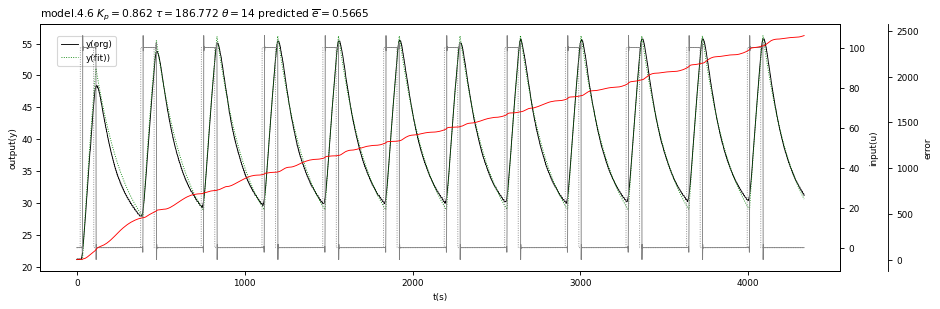

In [7]:
title = "$K_p=%.3f\ \\tau=%.3f\ \\theta=%d$"%(K,tau,theta)

_tclabutils.plot(t,u,y,u_=up,y_=yp,e_=ep,title="%s %s predicted $\overline{e}=%.4f$"%(name,title,ep.mean()))

### fodpt explizit estimation

$y_j=e^{\frac{-\Delta t}{\tau}}(y_{j-1}-y_0)+(1-e^{\frac{-\Delta t}{\tau}})K(u_j-u_0)+y_0$


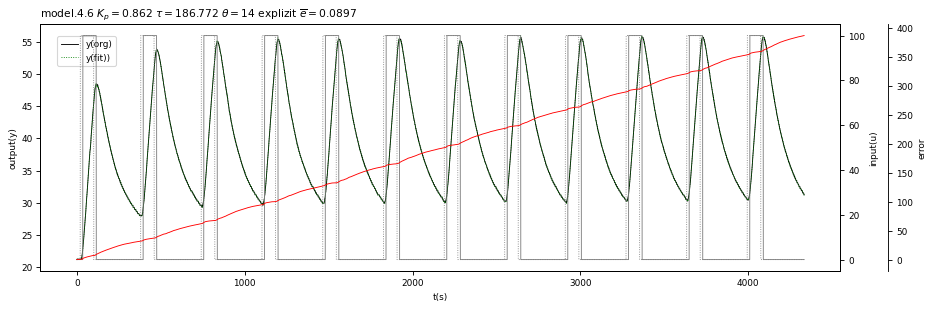

In [8]:

def estimate_explizit_(t,u,y,tau,theta):

  um = np.zeros(len(t))
  ym = np.zeros(len(t))

  um[0] = u[0]
  ym[0] = y[0]
  for i in range(1,len(t)):
    
    dt = t[i]-t[i-1]
    j = i-theta-1
    j = 0 if j<0 else j
    
    um[i] = u[j]
    ym[i] = np.exp(-dt/tau)*(y[i-1]-y[0]) + (1.-np.exp(-dt/tau)) * K * (u[j]-u[0]) + y[0]

  # error
  em = np.abs(y-ym)

  return um,ym,em

um,ym,em = estimate_explizit_(t,u,y,tau,theta)

_tclabutils.plot(t,u,y,u_=um,y_=ym,e_=em,title="%s %s explizit $\overline{e}=%.4f$"%(name,title,em.mean()))

### fopdt estimation

given parameters  

$K$, $\\tau$, $\\theta$

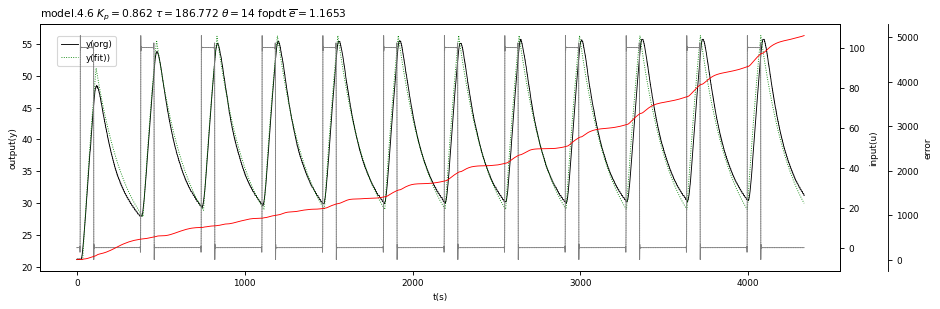

In [12]:
from scipy.integrate import odeint

def estimate_fopdt_(y,t, uf,K,tau,theta,u0,y0):
    
    # arguments
    
    #  y      = output
    #  t      = time
    #  u      = input linear function (for time shift)

    #  K      = gain
    #  tau    = time constant
    #  theta  = dead time

    h = int(t-theta)
    u_ = u0 if h <= 0 else uf[h]

    dydt = (-(y-y0)+K*u_)/tau

    return dydt

def build_fopdt_(tb,ub,yb, K,tau,theta):

  uo = ub.copy()
  uo[:-theta] = uo[theta:]

  yo = np.zeros(len(tb))
  yo[0] = yb[0]
  for i in range(len(tb)-1):
    ts = [tb[i],tb[i+1]]  
    y_ = odeint(estimate_fopdt_,yo[i],ts,args=(uo,K,tau,theta,uo[0],yb[0]))  
    yo[i+1] = y_[-1]

  # error
  eo = np.abs(yb-yo)
  
  return uo,yo,eo

uo,yo,eo = build_fopdt_(t,up,y, K,tau,theta)

_tclabutils.plot(t,u,y,u_=uo,y_=yo,e_=eo,title="%s %s fopdt $\overline{e}=%.4f$"%(name,title,eo.mean()))


### energy balance estimation with given parameters

$m\,c_p\frac{dT}{dt} = U\,A\,\left(T_\infty-T\right) + \epsilon\,\sigma\,A\,\left(T_\infty^4-T^4\right) + \alpha Q$

$\sigma$: Stefan Boltzmann constant  
$m$: mass  
$c_p$: heat cacpacity  
$\epsilon$: emisivity  
$A$: surface area  
$T_\infty$: ambient temperature  
$T$: actual temperature  
$Q$: heater output  
$\alpha=0.01$: heater factor  
$U$: overall heat transfer coefficient

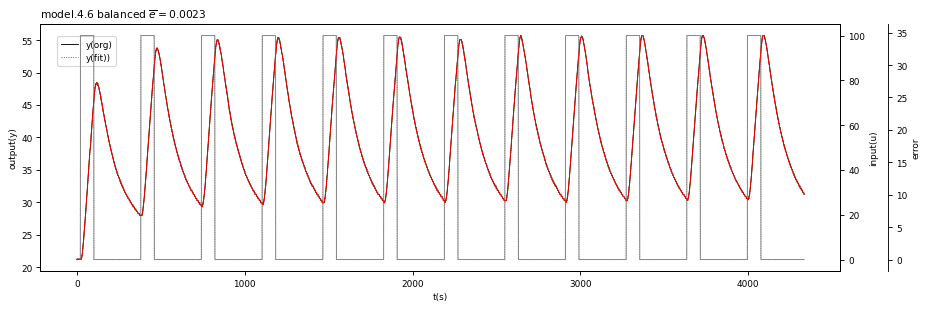

In [13]:
# energy balance fit

from _energy import energy_

tb,ub,yb,eb = energy_.estimate_(t,u,y)    

_tclabutils.plot(t,u,y,u_=ub,y_=yb,e_=eb,title="%s balanced $\overline{e}=%.4f$"%(name,eb.mean()))

### error comparison  

explizit and balanced surrogates should be a good estimation

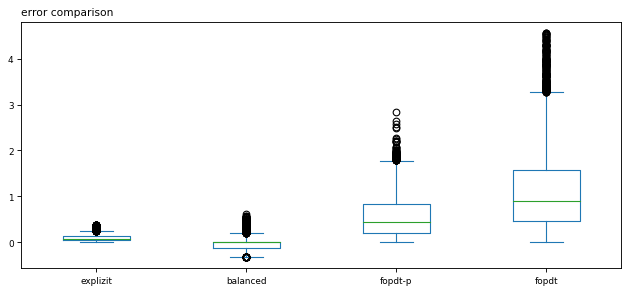

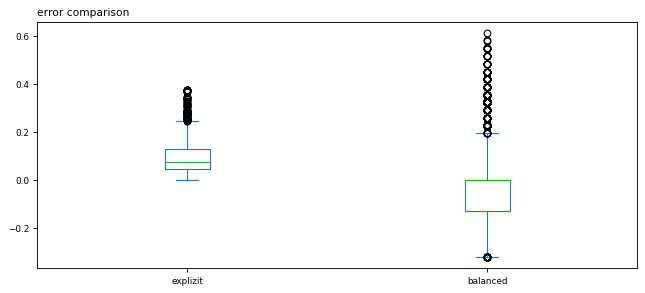

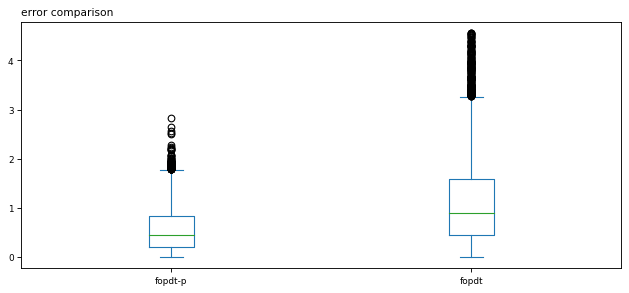

In [17]:
_tclabutils.error(pd.DataFrame(np.array([em,eb,ep,eo]).T,columns=['explizit','balanced','fopdt-p','fopdt']))

_tclabutils.error(pd.DataFrame(np.array([em,eb]).T,columns=['explizit','balanced']))
_tclabutils.error(pd.DataFrame(np.array([ep,eo]).T,columns=['fopdt-p','fopdt']))


In [25]:
ts = t[-360:]; ts = ts-ts.min()
us = u[-360:]
ys = y[-360:]

s_K,s_tau,s_theta,s_up,s_yp,s_ep = estimate_coefficients_(ts,us,ys)
print("K=%f tau=%f theta=%d"%(s_K,s_tau,s_theta))


K=0.461572 tau=93.878657 theta=20


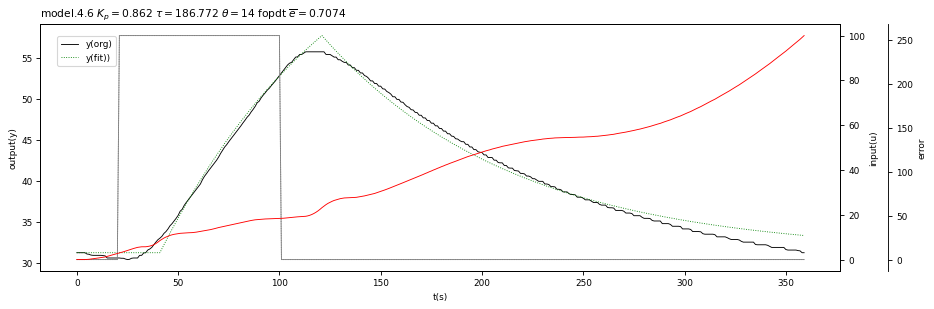

In [27]:
uo,yo,eo = build_fopdt_(ts,s_up,ys, s_K,s_tau,s_theta)

_tclabutils.plot(ts,us,ys,u_=uo,y_=yo,e_=eo,title="%s %s fopdt $\overline{e}=%.4f$"%(name,title,eo.mean()))

K=0.253300 tau=61.000000 theta=20


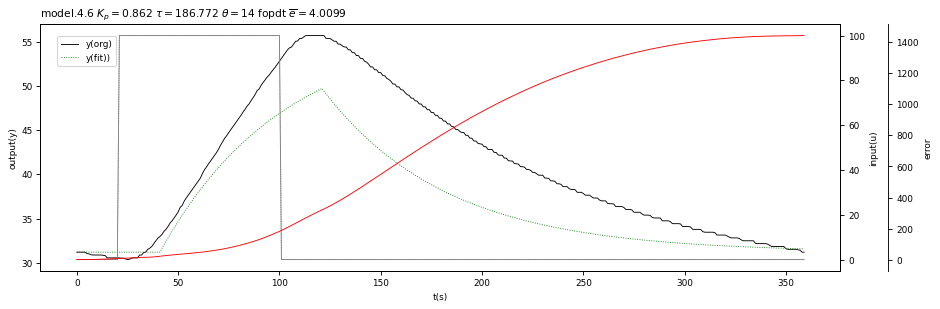

In [50]:

du = us.max()-us.min()
dy = ys.max()-ys.min()

m_K = dy/du
m_theta = 20

y0632 = dy*0.632+ys.min()
t0632 = t[np.argwhere(ys>=y0632)[0]]

m_tau = t0632 - m_theta

#m_K,m_theta,m_tau = s_K,s_theta,s_tau

print("K=%f tau=%f theta=%d"%(m_K,m_tau,m_theta))

# _tclabutils.plot(ts,us,ys,title=""%())

um,ym,em = build_fopdt_(ts,s_up,ys, m_K,m_tau,m_theta)

_tclabutils.plot(ts,us,ys,u_=um,y_=ym,e_=em,title="%s %s fopdt $\overline{e}=%.4f$"%(name,title,em.mean()))